# Assignment 4 - Group 9

Group members: Jonas Röst & Kailash de Jesus Hornig 

In [1]:
# Imports
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import scipy.linalg.blas as blas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Exercise question

In [2]:
X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print("First example: {}".format(accuracy_score(Y1, guesses1)))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print("Second example: {}".format(accuracy_score(Y2, guesses2)))


# Construct new example 
X3 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y3 = ['rain', 'sun', 'sun', 'rain']

classifier3 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))

classifier3.fit(X3, Y3)
guesses3 = classifier3.predict(X3)
print("Third example: {} ".format(accuracy_score(Y3, guesses3)))

First example: 1.0
Second example: 0.5
Third example: 0.5 


As can be seen from example 3 the problem is not with the input in X, but the Y values. Our hypothesis is that we have a case of linear inseparability in the second example, which makes it impossible to attain an accuracy of 1.

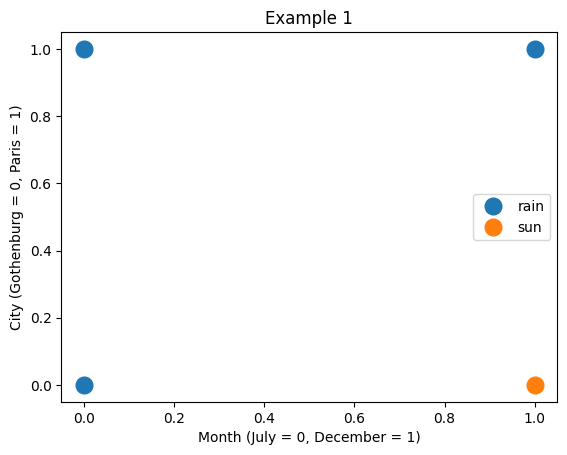

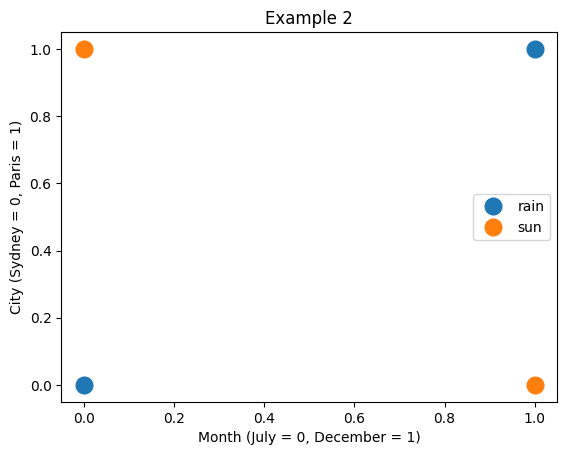

In [3]:
# Visualize difference in linear inseperability/seperability in the two examples. 

# Example 1
# Represent Gothenburg = 0, Paris = 1 and July = 0, December = 1
# Create a vectors of X2 using the representations:
rep_cities = [0,0,1,1]
rep_months = [0,1,0,1]

df_1 = pd.DataFrame({'x': rep_cities,
                   'y': rep_months,
                   'z': Y1})

groups = df_1.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.xlabel("Month (July = 0, December = 1)")
plt.ylabel("City (Gothenburg = 0, Paris = 1)")
plt.title("Example 1")
plt.legend()
plt.show()

# Example 2
# Represent Sydney = 0, Paris = 1 and July = 0, December = 1
# Create a vectors of X2 using the representations:
rep_cities = [0,0,1,1]
rep_months = [0,1,0,1]

df_2 = pd.DataFrame({'x': rep_cities,
                   'y': rep_months,
                   'z': Y2})

groups = df_2.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.xlabel("Month (July = 0, December = 1)")
plt.ylabel("City (Sydney = 0, Paris = 1)")
plt.title("Example 2")
plt.legend()
plt.show()

As can be seen in the plots, we have linear separability in the first plot (Example 1) but not in the second (Example 2). This means that no linear classifier can achieve an accuracy of 1 in the second example as there is no line that perfectly separates the "rain" data points from the "sun" data points. Hence, we get an accuracy of 0.5 in the second example even though we run it on the same data set. The classifier learns a line not the individual placements of data points. 

# Task

## LinearClassifier Super Class

In [4]:
# Super class taken from the code examples given in the assignment.
# Using this made implementations of Logistic Regression and SVC easier.
class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


The below implementations of SVC and Logistic Regression use the skeleton from the Perceptron-class given in the assignment.

## Implement the SVC

In [5]:
class Pegasos_SVC(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for SVC
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]
            y = Ye[random_idx]
            eta = 1/(self.lam*t)
            score = self.decision_function(x)

            if y*score < 1:
                self.w = (1 - eta*self.lam)*self.w + (eta*y)*x
            else:
                self.w = (1 - eta*self.lam)*self.w
            

## Implement Logistic Regression

In [6]:
class Pegasos_LogReg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]
            y = Ye[random_idx]
            eta = 1/(self.lam*t)

            self.w = (1-eta*self.lam)*self.w + (x*eta*y)/(1+np.exp(y*self.decision_function(x)))
                
            

## Compare SVC against Logistic Regression

The below code cell runs and evaluates the SVC and Logistic Regression models that are implemented above. We can see that models attain the same accuracy of 0.8334 but the SVC is slightly faster than the Logistic Regression.

In [7]:
# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

    
# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    
    Pegasos_SVC() 
)

logreg_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    
    Pegasos_LogReg()
)

# Train the SVC classifier.
t0 = time.time()
svc_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('SVC training time: {:.2f} sec.'.format(t1-t0))

# Evaluate SVC on the test set.
Yguess = svc_pipeline.predict(Xtest)
print('SVC accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))


# Train the Logistic Regression classifier.
t0 = time.time()
logreg_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Logistic Regression training time: {:.2f} sec.'.format(t1-t0))

# Evaluate Logistic Regression on the test set.
Yguess = logreg_pipeline.predict(Xtest)
print('Logistic Regression accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))
    

SVC training time: 4.95 sec.
SVC accuracy: 0.8317.
/tmp/ipykernel_73/2464952634.py:34: RuntimeWarning: overflow encountered in exp
  self.w = (1-eta*self.lam)*self.w + (x*eta*y)/(1+np.exp(y*self.decision_function(x)))
Logistic Regression training time: 5.72 sec.
Logistic Regression accuracy: 0.8338.


# Bonus task #1

We choose to solve bonus task #1 - Making your code more efficient. Our solutions are implemented below and we work only with the Logistic Regression model.

## (a) Faster linear algebra operations

In order to achieve faster linear algebra operations we use methods from scipy.linalg.blas.

In [8]:
class Pegasos_LogReg_faster_linalg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]
            y = Ye[random_idx]
            eta = 1/(self.lam*t)

            # Store current self.w in separate variable because the unscaled version 
            #is used in the second term of the update function
            w = self.w

            # Performe scaling of w
            blas.dscal((1-eta*self.lam), self.w)
            
            # Compute the new w 
            blas.daxpy(x, self.w, a = (eta*y)/(1+np.exp(y * blas.ddot(x, w))))


## (b) Using sparse vectors

Removing the SelectKBest from the pipeline results in a much worse training time of 162 seconds and a slight decrease in accuracy. When adding the option ngram_range=(1,2) to the TFIDVectorizer we also get a worse training time, 7.8 seconds. However, the accuracy of the model increases by approximately 0.01. 

In [9]:
logreg_pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    SelectKBest(k=1000),
    Normalizer(),
    
    Pegasos_LogReg()
)

# Train the Logistic Regression classifier.
t0 = time.time()
logreg_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Logistic Regression training time: {:.2f} sec.'.format(t1-t0))

# Evaluate Logistic Regression on the test set.
Yguess = logreg_pipeline.predict(Xtest)
print('Logistic Regression accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

/tmp/ipykernel_73/2464952634.py:34: RuntimeWarning: overflow encountered in exp
  self.w = (1-eta*self.lam)*self.w + (x*eta*y)/(1+np.exp(y*self.decision_function(x)))
Logistic Regression training time: 8.53 sec.
Logistic Regression accuracy: 0.8410.


In [10]:
# Utility functions
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)

In [11]:
class Sparse_Pegasos_LogReg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        self.w = np.zeros(X.shape[1])

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]
            y = Ye[random_idx]
            eta = 1/(self.lam*t)

            factor = (eta*y)/(1+np.exp(y*sparse_dense_dot(x,self.w))) 
 
            # Scale self.w
            blas.dscal((1-eta*self.lam), self.w)

            # Update self.w
            add_sparse_to_dense(x, self.w, factor)
                
            

## (c) Speeding up the scaling operation

In [12]:
# Extending the solution in (b)
class Sparse_and_sped_up_scaling_Pegasos_LogReg(LinearClassifier):

    def __init__(self, n_iter=100000):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.lam = 1/X.shape[0]

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        self.w = np.zeros(X.shape[1])

        # Intitialize scaling vector
        a = 1

        # Pegasos algorithm for logistic regression
        for t in range(1, self.n_iter+1): # Repeat
            random_idx = np.random.randint(X.shape[0])
            
            x = X[random_idx]
            y = Ye[random_idx]
            eta = 1/(self.lam*t)

            # a added to np.exp(...) to change the dot product between 
            #the weight vector and the feature vector as described in a4_clarification.pdf
            factor = (eta*y)/((1+np.exp(y*a*sparse_dense_dot(x,self.w))))

            # Scale scaling factor
            if t != 1: # When t = 1, (1-eta*self.lam) becomes 0
                a = a*(1-eta*self.lam)

            # “compensate” for the fact that we eventually will scale w by a
            factor = factor / a

            # Update self.w
            add_sparse_to_dense(x, self.w, factor)
        
        # Scale w with the postponed scaling
        self.w *= a
                
            

## Test new models against the original

In [13]:
# Compare a new, improved model to baseline Logistic Regression
def eval_comparison(classifier, name_of_classifier):

    orig_logreg_pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),
        
        Pegasos_LogReg()
    )

    new_pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),
        
        classifier # denna var inte arguemt tidigare?
    )

    # Train the original Logistic Regression classifier.
    t0 = time.time()
    orig_logreg_pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    orig_time = t1-t0

    # Evaluate original on the test set.
    Yguess = orig_logreg_pipeline.predict(Xtest)
    
    orig_results_dict = {
        'version': 'Original  Pegasos_LogReg',
        'accuracy': round(accuracy_score(Ytest, Yguess),4),
        'time': round(t1-t0, 4),
        'diff' : 0
    }
    
    
    # Train the new Logistic Regression classifier.
    t0 = time.time()
    new_pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    new_time = t1-t0
    
    # Evaluate new Logistic Regression on the test set.
    Yguess = new_pipeline.predict(Xtest)
    
    time_diff = -(orig_results_dict['time']-new_time)
    new_results_dict = {
        'version': str(name_of_classifier),
        'accuracy': round(accuracy_score(Ytest, Yguess),4),
        'time': round(t1-t0, 4),
        'diff' : round(time_diff, 4)
    }

    
    return orig_results_dict, new_results_dict

In [14]:
#Create a panda to present the result in a neat way
results_list = []

#Runt tests
dict1, dict2 = eval_comparison(Pegasos_LogReg_faster_linalg(), "Faster linalg LogReg")
dict0, dict3 = eval_comparison(Sparse_Pegasos_LogReg(), "Sparse LogReg")
dict00, dict4 =eval_comparison(Sparse_and_sped_up_scaling_Pegasos_LogReg(), "Sparse and sped up scaling LogReg")
results_list.append(dict1)
results_list.append(dict2)
results_list.append(dict3)
results_list.append(dict4)

# Creating a pandas DataFrame
df = pd.DataFrame(results_list)
#df = pd.DataFrame(dict1, dict2, dict3, dict4) # try to eliminate the appends

# Printing the resulting table
df.head()


/tmp/ipykernel_73/2596888072.py:28: RuntimeWarning: overflow encountered in exp
  factor = (eta*y)/(1+np.exp(y*sparse_dense_dot(x,self.w)))
/tmp/ipykernel_73/2464952634.py:34: RuntimeWarning: overflow encountered in exp
  self.w = (1-eta*self.lam)*self.w + (x*eta*y)/(1+np.exp(y*self.decision_function(x)))
/tmp/ipykernel_73/4085754109.py:34: RuntimeWarning: overflow encountered in exp
  factor = (eta*y)/((1+np.exp(y*a*sparse_dense_dot(x,self.w))))


,version,accuracy,time,diff
0,Original Pegasos_LogReg,0.8338,4.2184,0.0000
1,Faster linalg LogReg,0.8334,3.2234,-0.9950
2,Sparse LogReg,0.8376,19.4781,15.3467
3,Sparse and sped up scaling LogReg,0.8326,32.9521,28.8900


The results presented in the DataFrame above indicate that the implementation speeding up the linear algebra is the only implementation that performs better than the original Logistic Regression in terms of training time. The two implementations using sparse matrices perform quite a lot worse, getting 19.6 and 16.1 seconds worse training time than the original logistic regression model. This was surprising to us as we thought that all implementations would improve the speed it took to train the Logistic Regression model. Nevertheless, one benefit that comes with using the sparse matrices is the reduced use of memory which is an improvement in itself, especially if we were to use the model on an even bigger data set. We tried to run the two sparse models in a local Jupyter Notebook as well, which resulted in better training time than when we ran it using Deepnote. Running them locally results in training times that are only 4.8 seconds worse than the original Logistic Regression model. This big difference might indicate that Deepnote is not as optimized for using sparse matrices. 

From the results, we can draw the conclusion that the main bottleneck of the original algorithm is the linear algebra being used. Implementing faster methods for linear algebra was the only thing that made the Logistic Regression model faster. Also, when evaluated using Deepnote, the sped-up scaling implemented on the sparse implementation resulted in better training time, compared to the only-sparse implementation. This result is intuitive as the solution reduces the number of computations that are carried out during training because we only scale the weight vector once instead of 100 000 times. 

## Exploring trade-off speed vs performance by variying SelectKBest

We had a hypothesis that reducing the number of features that the model considers could also reduce the training time of the models, since removing SelectKBest from the pipeline previously resulted in radically worse training times. Hence, we wanted to try different values of k in SelectKBest used in our pipeline. Our results from this exploration are found below.

In [15]:
# Adjusted code to vary k-value
# Compare to baseline Logistic Regression
def eval_comparison(classifer, name_of_classifier, other_k):

    orig_logreg_pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=other_k),
        Normalizer(),
        Pegasos_LogReg()
    )

    new_pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=other_k),
        Normalizer(), 
        classifer
    )

    # Train the original Logistic Regression classifier.
    t0 = time.time()
    orig_logreg_pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    orig_time = t1-t0
    #print('Original Logistic Regression training time: {:.2f} sec.'.format(orig_time))

    # Evaluate original on the test set.
    Yguess = orig_logreg_pipeline.predict(Xtest)
    #print('Original Logistic Regression accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))
    
    orig_results_dict = {
        'version': 'Original  Pegasos_LogReg',
        'accuracy': accuracy_score(Ytest, Yguess),
        'time': t1-t0,
        'diff' : 0
    }
    
    
    # Train the new classifier.
    t0 = time.time()
    new_pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    new_time = t1-t0
    
    # Evaluate new Logistic Regression on the test set.
    Yguess = new_pipeline.predict(Xtest)
    
    time_diff = -(orig_results_dict['time']-new_time)
    new_results_dict = {
        'version': str(name_of_classifier),
        'accuracy': accuracy_score(Ytest, Yguess),
        'time': t1-t0,
        'diff' : time_diff
    }
    
    return orig_results_dict, new_results_dict



In [16]:
#Create a panda to present the result in a  neat way

k_vals = [500, 100, 10, 5]

# Create holders for the different scores 
#accuracy
original_acc = []
faster_linalg_acc = []
sparse_acc = []
fast_sparse_acc = []
#time
original_t = [] 
faster_linalg_t = []
sparse_t = []
fast_sparse_t = []

# For each k-value
for k_val in k_vals:
    results_list = []
    dict1, dict2 = eval_comparison(Pegasos_LogReg_faster_linalg(), "Faster linalg LogReg",k_val)
    dict0, dict3 = eval_comparison(Sparse_Pegasos_LogReg(), "Sparse LogReg",k_val)
    dict00, dict4 =eval_comparison(Sparse_and_sped_up_scaling_Pegasos_LogReg(), "Sparse and sped up scaling LogReg",k_val)
    results_list.append(dict1)
    results_list.append(dict2)
    results_list.append(dict3)
    results_list.append(dict4)
    
    #create list for each version holding the accuracy for every k-loop
    original_acc.append(dict1['accuracy'])
    faster_linalg_acc.append(dict2['accuracy'])
    sparse_acc.append(dict3['accuracy'])
    fast_sparse_acc.append(dict4['accuracy'])
    
    # same for time
    original_t.append(dict1['time'])
    faster_linalg_t.append(dict2['time'])
    sparse_t.append(dict3['time'])
    fast_sparse_t.append(dict4['time'])
    

    # Creating a pandas DataFrame
    df = pd.DataFrame(results_list)
    print('now running: ' + str(k_val))
    print(df)

now running: 500
                             version  accuracy       time       diff
0           Original  Pegasos_LogReg  0.821653  10.304830   0.000000
1               Faster linalg LogReg  0.822912   9.176431  -1.128399
2                      Sparse LogReg  0.825010  50.350911  39.561722
3  Sparse and sped up scaling LogReg  0.826269  46.178411  35.065065
/tmp/ipykernel_73/1032629681.py:41: RuntimeWarning: overflow encountered in exp
  blas.daxpy(x, self.w, a = (eta*y)/(1+np.exp(y * blas.ddot(x, w))))
/tmp/ipykernel_73/2464952634.py:34: RuntimeWarning: overflow encountered in exp
  self.w = (1-eta*self.lam)*self.w + (x*eta*y)/(1+np.exp(y*self.decision_function(x)))
now running: 100
                             version  accuracy       time       diff
0           Original  Pegasos_LogReg  0.786823   9.805422   0.000000
1               Faster linalg LogReg  0.783466   8.698952  -1.106471
2                      Sparse LogReg  0.784725  46.996353  37.982942
3  Sparse and sped up scaling

The results did not quite agree with our hypothesis, as can be seen in the plotted figure with bars and line graphs. Starting with selecting the 1 000 highest-scoring features, out of the inial 41 684, we expected the times to decrease. As it turned out, lowering the number of selected features from 1 000 did not have any mentionable impact on the time it takes to train the different models. We assume that the number of features would have had to vary with much larger numbers to affect the training time and the operations that take the longest time don't depend on a couple of hundred more features. However, the accuracy of the models went down significantly from just above 80% with 1 000 features, to just above 60% with 5 features. The fact that only 5 features still resulted in a fairly good score was a little surprising and hence we continued to investigate the selected terms by getting the best 20 words.  

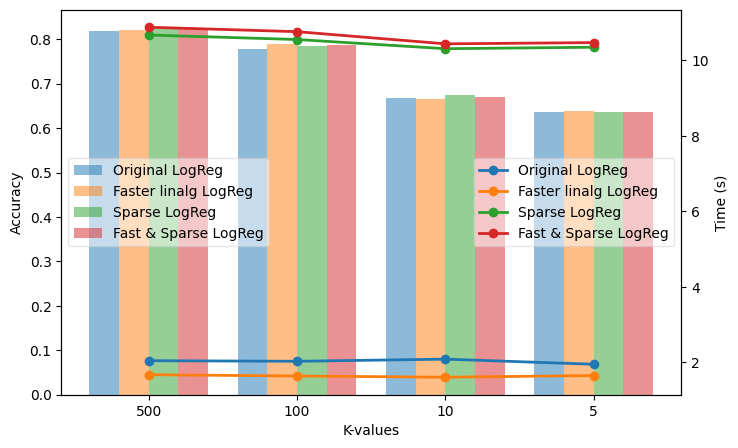

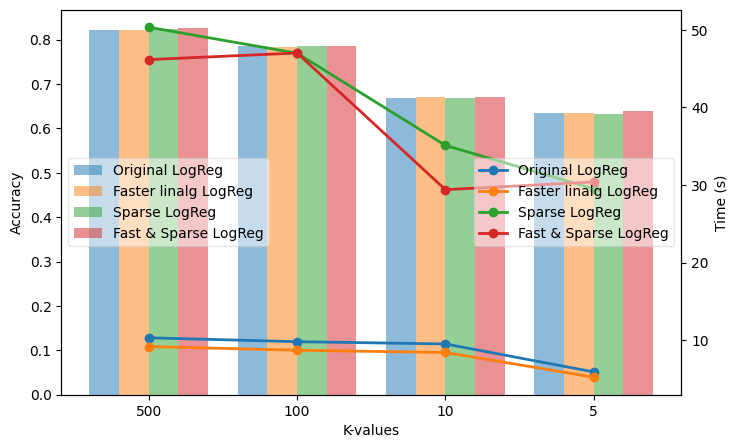

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# create some example data
k_values = k_vals
test_names = ['Original LogReg', 'Faster linalg LogReg', 'Sparse LogReg', 'Fast & Sparse LogReg']

tot_acc_lists= [original_acc, faster_linalg_acc, sparse_acc, fast_sparse_acc]
tot_time_lists = [original_t, faster_linalg_t, sparse_t, fast_sparse_t]
accuracy_scores = tot_acc_lists
times = tot_time_lists

# create a figure and axis object for the bar chart
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot the accuracy scores as a bar chart
x = np.arange(len(k_values))
for i in range(len(test_names)):
    width =0.2
    ax1.bar(x + (i - 1.5) * width, accuracy_scores[i], width, align='center', alpha=0.5)
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(k_values)

# create a twin axis object for the line graphs
ax2 = ax1.twinx()

# plot the times as line graphs
for i in range(len(test_names)):
    ax2.plot(x, times[i], 'o-', linewidth=2.0)
ax2.set_ylabel('Time (s)')

# set the x-axis label
ax1.set_xlabel('K-values')

# legend
accuracy_legend = ax1.legend(test_names, loc = 'center left')
time_legend = ax2.legend(test_names, loc='center right')
accuracy_legend.get_frame().set_alpha(0.5)
time_legend.get_frame().set_alpha(0.5)

plt.show()


### Investigating the top 20 best features from SelectKBest

The fact that the accuracy of the different models still was above 60% even when 99% of the total number of terms were eliminated shows that the grand majority of terms don't contribute to the decision. The number of ≈40 000 terms also seems exaggerated for shorter reviews and many of the words are probably variations of the same words or even typos. 

The expectation was to find words that state a clear sentiment of being either positive or negative in the review text since the highest-ranking words are supposed to be the best for deciding the classification. The results were much in line with this intuition and multiple words such as "bad", "best", "boring", and "excellent" were found. Other words included, were typical insignificant words like "and", "but", "and did" which could have been included in a stoplist. 

In [18]:
# Create an instance of the TfidfVectorizer class
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(Xtrain) # out data

# Create an instance of the SelectKBest, fit and get 
#the indices of the k-best features
kbest = SelectKBest(k=20)
kbest.fit(tfidf_matrix, Ytrain) # right lable? 
kbest_indices = kbest.get_support(indices=True)

# Get the names of the k-best features
feature_names = tfidf.get_feature_names_out()
kbest_feature_names = [feature_names[i] for i in kbest_indices]

print("Top 20 Features:")
print("----------------")
for feature in kbest_feature_names[:20]:
    print(feature)

Top 20 Features:
----------------
and
bad
best
boring
but
did
easy
excellent
great
highly
love
money
no
not
nothing
poor
support
was
waste
worst
Top 20 Features:
----------------
and
bad
best
boring
but
did
easy
excellent
great
highly
love
money
no
not
nothing
poor
support
was
waste
worst


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=91294706-5412-4c53-b64a-ecb74941a413' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>